In [1]:
import json
import os
from datetime import datetime
from multiprocessing.pool import ThreadPool

In [2]:
PARALLEL_PROCESSES = 16

In [3]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape

In [4]:
def compute_occupied_area(features):
    """
    Returns occupied area for list of features in square km
    """
    occupied = features
    geom = [shape(i['geometry']) for i in occupied]
    gdf = gpd.GeoDataFrame({'geometry': geom}, crs='EPSG:4326')
    # https://stackoverflow.com/questions/38961816/geopandas-set-crs-on-points
    gdf = gdf.to_crs('EPSG:3857')  # convert to metric projection
    # https://gis.stackexchange.com/questions/254413/how-to-fix-hole-lies-outside-shell
    # https://gis.stackexchange.com/questions/253224/geopandas-buffer-using-geodataframe-while-maintaining-the-dataframe
    gdf['geometry'] = gdf.geometry.buffer(0)
    joined = gdf.dissolve(by=None)
    return float(round(joined.area, 2) / 1e6)

In [5]:
def process_item(args):
    idx, filename = args
    print(f"(Processing {idx}", end='\r')
    with open(os.path.join('data', filename)) as f:
        data = json.load(f)
    id_ = filename.split('.json')[0]
    date = datetime.strptime(id_, '%Y-%m-%d')
    # https://gis.stackexchange.com/questions/329349/calculating-the-area-by-square-feet-with-geopandas
    area = compute_occupied_area(data['value']['features'])  
    return [id_, date, area, data['value']['features']]

In [6]:
# process_item([0, '2022-02-24.json'])

In [7]:
processed = []
files = os.listdir('data')

def dispatch(items):
    print(f"Processing all {len(items)} items...")
    return list(ThreadPool(
        PARALLEL_PROCESSES).imap_unordered(process_item, enumerate(items)))

In [8]:
processed = dispatch(files)

Processing all 380 items...


# Plotting total territory control

In [64]:
df = pd.DataFrame(processed, columns=['id', 'date', 'area', 'features'])
df = df.drop(['id'], axis=1)
df = df.sort_values(by='date', ascending = True)

In [65]:
df = df.set_index('date')

In [66]:
df['area'] = df['area'].astype('float')

<AxesSubplot: xlabel='Date', ylabel='Russian-occupied Ukrainian territory in km²'>

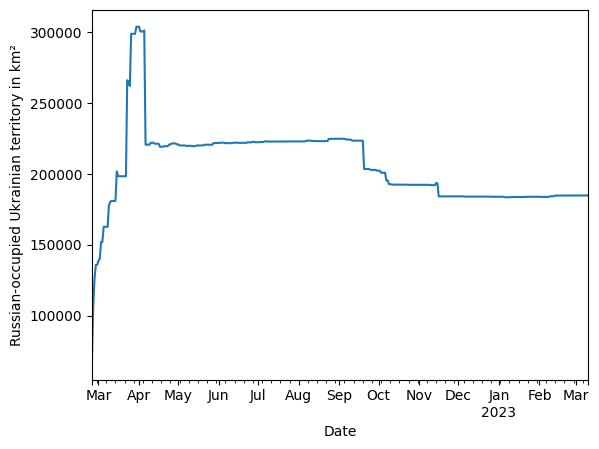

In [73]:
df['area'].plot(xlabel='Date', ylabel='Russian-occupied Ukrainian territory in km\u00b2')

In [53]:
df.to_csv('nzz_area_occupied.csv')

In [54]:
df.to_excel('nzz_area_occupied.xlsx')

# Mapping territory

In [55]:
from ipyleaflet import Map, GeoJSON
import ipywidgets

In [58]:
selection_slider = ipywidgets.SelectionSlider(options=list(df.index),
                                              value=datetime(2022, 2, 24),
                                              description='Slider',
                                              disabled=False,
                                              continuous_update=False,
                                              orientation='horizontal',
                                              readout=True)

In [59]:
m = Map(center=(48.1928465, 37.8562077), zoom=5)
display(m)

def plot_date(date):
    entry = df.loc[df.index == date]
    idx, row = next(entry.iterrows())
    fc =   {
        'type': 'FeatureCollection',
        'features': row.loc['features'],
    }
    geo_json = GeoJSON(
        data=fc,
    )
    # Clear potential overlays from previous day selection
    m.clear_layers()
    m.add_layer(geo_json)

ipywidgets.interact(plot_date, date=selection_slider)

Map(center=[48.1928465, 37.8562077], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

interactive(children=(SelectionSlider(continuous_update=False, description='Slider', options=(Timestamp('2022-…

<function __main__.plot_date(date)>

# Plotting territory control change

In [70]:
# Calculate change to previous day which translates to daily gains/losses
df['change'] = df['area'].diff()

<AxesSubplot: xlabel='Date', ylabel='Net territory control change in km²'>

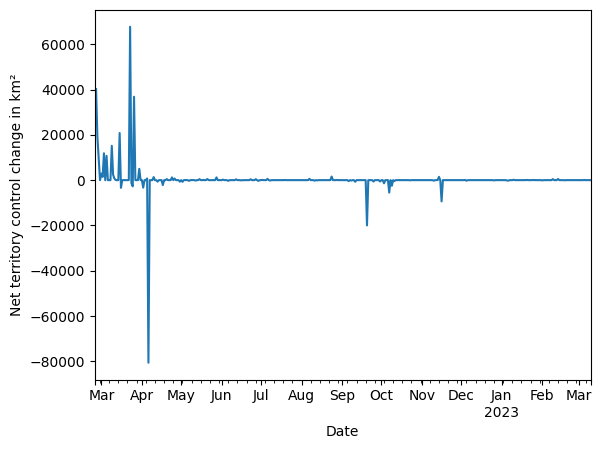

In [74]:
df['change'].plot(xlabel='Date', ylabel='Net territory control change in km\u00b2')